In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-dataset/car.csv


# Predicting Car Selling Price


In [2]:
!pip install -q xgboost
!pip install -q catboost

In [3]:
# Importing necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer # For Log transforming target and, separating Transformation of numerical and categorical datas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Our evaluation metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split # Hyperparameters tuning, dataset spliiting
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer # Feature scaling, Encode categorical data and FunctionTransformer for log transformation
from sklearn.pipeline import Pipeline # Chain preprocessing and model
from sklearn.feature_selection import SelectFromModel # For feature selection

## Regression Models
from sklearn.linear_model import Ridge # L2 regularized Linear reression model
from sklearn.svm import SVR # Support Vector Regressor
### Bagging and Boosting based ensembled tree models, ExtraTreesRegressor for feature Selection and a voting ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from xgboost import XGBRegressor # extreme gradient booosting regressor 
from lightgbm import LGBMRegressor # another gradient boosting model
from sklearn.neighbors import KNeighborsRegressor # k-nearest neighbors regression

import random
import joblib # To serialize the model for deployment
import warnings
warnings.filterwarnings('ignore')

'''
Other Libraries might be imported if required
'''

# Importing dataset
dataset_path = "/kaggle/input/car-dataset/car.csv"
df = pd.read_csv(dataset_path)

## Setting Global Seed
### LLM usage: set global seed for reproducibility, while providing code I use for deep learning  

In [4]:
def set_seed(seed=42):
    """
    Sets the random seed for Python, NumPy, and other libraries to ensure 
    reproducibility of results.
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seed set to {seed}")

set_seed(42)

Random seed set to 42


## Data Cleaning
Here is where we investigate the dataset for irregularities, making sure the information are correct to train the models

In [5]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                8128 non-null   object 
 1   year                8128 non-null   int64  
 2   selling_price       8128 non-null   int64  
 3   km_driven           8128 non-null   int64  
 4   fuel                8128 non-null   object 
 5   seller_type         8128 non-null   object 
 6   transmission        8128 non-null   object 
 7   owner               8128 non-null   object 
 8   mileage(km/ltr/kg)  7907 non-null   float64
 9   engine              7907 non-null   float64
 10  max_power           7913 non-null   object 
 11  seats               7907 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 762.1+ KB


### LLM usage: Describe dataset and commenting on missing datas
The dataset contains **8,128 rows** and **12 columns**, representing a collection of used car listings. The goal is to predict the `selling_price` based on the other 11 features. The data is a typical mix of numerical and categorical (text-based) information.

#### **Column-by-Column Breakdown:**

*   **`name`** (Categorical/Object): The full model name of the car (e.g., "Maruti Swift Dzire VDI"). This contains both brand and model information.
*   **`year`** (Numerical/int64): The year the car was manufactured. This will be a key feature for determining the car's age and depreciation.
*   **`selling_price`** (Numerical/int64): The price at which the car was sold, in the local currency. **This is the target variable.** Probably in INR
*   **`km_driven`** (Numerical/int64): The total kilometers the car has been driven. This is a critical indicator of wear and tear.
*   **`fuel`** (Categorical/Object): The type of fuel the car uses (e.g., Petrol, Diesel, CNG).
*   **`seller_type`** (Categorical/Object): Specifies who is selling the car.
*   **`transmission`** (Categorical/Object): The car's transmission type (Manual or Automatic).
*   **`owner`** (Categorical/Object): Describes the ownership history (e.g., First Owner, Second Owner).
*   **`mileage(km/ltr/kg)`** (Numerical/float64): The fuel efficiency of the car. This is a numerical feature but has some missing values.
*   **`engine`** (Numerical/float64): The engine capacity in cubic centimeters (CC). This is also a numerical feature with missing values.
*   **`max_power`** (Categorical/Object): The maximum power output of the engine, typically in brake horsepower (bhp). **Crucially, this is incorrectly typed as `object`**, meaning it contains non-numeric characters that must be cleaned.
*   **`seats`** (Numerical/float64): The number of seats in the car. It's stored as a float but represents a discrete integer value. It also has missing data.

#### **1. Incorrect Data Type (`max_power`)**

The most immediate problem is that `max_power` is an `object` type.  We **must** convert this feature to numerical format(`float`) before training models

#### **2. Missing Values Analysis**

Missing data in four important feature columns:

*   **`mileage(km/ltr/kg)`:** Missing 221 values (8128 - 7907). This is **~2.7%** of the dataset.
*   **`engine`:** Missing 221 values (**~2.7%**).
*   **`seats`:** Missing 221 values (**~2.7%**).
*   **`max_power`:** Appears to be missing 215 values.

In [7]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage(km/ltr/kg)', 'engine', 'max_power',
       'seats'],
      dtype='object')

In [8]:
df.tail()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
8123,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197.0,82.85,5.0
8124,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493.0,110,5.0
8125,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.30,1248.0,73.9,5.0
8126,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57,1396.0,70,5.0
8127,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57,1396.0,70,5.0


In [9]:
df_copy = df.copy()

try: 
    df_copy["max_power"] = df_copy["max_power"].astype(float)

except ValueError as e:
    '''
    Ensuring this operation doesn't halt all cells' execution
    '''
    print(f"\nDirect conversion failed. Error: {e}")



Direct conversion failed. Error: could not convert string to float: ' '


There appears to be space character which can be set as NaN

In [10]:
df_copy = df.copy()
df_copy["max_power"] = pd.to_numeric(df_copy["max_power"], errors='coerce')

In [11]:
df_copy.describe()

,year,selling_price,km_driven,mileage(km/ltr/kg),engine,max_power,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000,7907.000000,7912.000000,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,19.418783,1458.625016,91.517919,5.416719
std,4.044249,8.062534e+05,5.655055e+04,4.037145,503.916303,35.822499,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,0.000000,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,16.780000,1197.000000,68.050000,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,82.000000,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,22.320000,1582.000000,102.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,14.000000


### Let's get LLM's help to not show scientific notation

In [12]:
# Set pandas display options to format floats instead of using scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [13]:
df_copy.describe()

,year,selling_price,km_driven,mileage(km/ltr/kg),engine,max_power,seats
count,8128.00,8128.00,8128.00,7907.00,7907.00,7912.00,7907.00
mean,2013.80,638271.81,69819.51,19.42,1458.63,91.52,5.42
std,4.04,806253.40,56550.55,4.04,503.92,35.82,0.96
min,1983.00,29999.00,1.00,0.00,624.00,0.00,2.00
25%,2011.00,254999.00,35000.00,16.78,1197.00,68.05,5.00
50%,2015.00,450000.00,60000.00,19.30,1248.00,82.00,5.00
75%,2017.00,675000.00,98000.00,22.32,1582.00,102.00,5.00
max,2020.00,10000000.00,2360457.00,42.00,3604.00,400.00,14.00


### Statistical Analysis
- Most numerical features except `year` seems to be right skewed as mean > median. Also, standard deviation indicates high variability(potentially due to luxury cars) for selling price. Log transformation during feature engineering can make the distribution more symmetric.
- **Incorrect Datas** : A minimum value of 0 for mileage and max_power is not possible. These feature instance/s will be replaced with NaN.
- The max value for features: year, selling_price, mileage, engine, max_power looks fine while km_driven and seats are suspicious of being extreme outliers


In [14]:
# Replacing incorrect 0 datas
df_copy['mileage(km/ltr/kg)'].replace(0, np.nan, inplace=True)
df_copy['max_power'].replace(0, np.nan, inplace=True)

In [15]:
high_km_driven = df_copy[df_copy['km_driven'] > df_copy['km_driven'].quantile(0.75)]
high_km_driven.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2024 entries, 0 to 8125
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                2024 non-null   object 
 1   year                2024 non-null   int64  
 2   selling_price       2024 non-null   int64  
 3   km_driven           2024 non-null   int64  
 4   fuel                2024 non-null   object 
 5   seller_type         2024 non-null   object 
 6   transmission        2024 non-null   object 
 7   owner               2024 non-null   object 
 8   mileage(km/ltr/kg)  1931 non-null   float64
 9   engine              1935 non-null   float64
 10  max_power           1934 non-null   float64
 11  seats               1935 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 205.6+ KB


In [16]:
# Checking the extreme outliers
high_km_driven.sort_values(by='km_driven', ascending=False).head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
3486,Hyundai i20 Asta 1.2,2007,550000,2360457,Petrol,Individual,Manual,Second Owner,18.60,1197.00,81.83,5.00
1810,Mahindra XUV500 W6 2WD,2012,500000,1500000,Diesel,Individual,Manual,First Owner,15.10,2179.00,140.00,7.00
3508,Maruti Wagon R LXI Minor,2010,194000,577414,Petrol,Individual,Manual,Second Owner,18.90,1061.00,67.00,5.00
6673,Toyota Innova 2.5 EV Diesel PS 7 Seater BSIII,2011,350000,500000,Diesel,Individual,Manual,Second Owner,12.99,2494.00,100.57,7.00
3641,Maruti Wagon R VXI BS IV,2011,229999,500000,Petrol,Individual,Manual,Second Owner,18.90,998.00,67.10,5.00
5106,Mahindra Scorpio M2DI,2011,400000,475000,Diesel,Individual,Manual,Third Owner,13.50,2179.00,115.00,5.00
5189,Toyota Innova 2.5 VX (Diesel) 7 Seater,2013,750000,440000,Diesel,Individual,Manual,Second Owner,12.99,2494.00,100.60,7.00
5467,Toyota Innova 2.5 VX (Diesel) 7 Seater BS IV,2010,950000,426000,Diesel,Individual,Manual,First Owner,12.80,2494.00,102.00,7.00
2272,Mahindra Bolero SLE,2010,260000,380000,Diesel,Individual,Manual,Second Owner,13.60,2523.00,63.00,7.00
7102,Toyota Innova 2.5 V Diesel 8-seater,2007,350000,376412,Diesel,Individual,Manual,Second Owner,12.80,2494.00,102.00,8.00


### LLM use: Interpreting above data for entry errors and possibly dropping faulty data
**Remove the most egregious and physically implausible data points.** A good, defensible strategy is to set a reasonable upper limit on what is possible for a car. For example, a threshold of 600,000 km seems very generous.

In [17]:
# Remove rows above 600000 kms driven
original_rows = len(df_copy)
df_copy = df_copy[df_copy['km_driven'] <= 600000]

print(f"\nRemoved {original_rows - len(df_copy)} rows with implausible km_driven values.")
print(f"New maximum km_driven: {df_copy['km_driven'].max()}")


Removed 2 rows with implausible km_driven values.
New maximum km_driven: 577414


In [18]:
# Investigating seats above 5 
seats_above_5 = df_copy[df_copy['seats'] > 5]
seats_above_5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1517 entries, 16 to 8113
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                1517 non-null   object 
 1   year                1517 non-null   int64  
 2   selling_price       1517 non-null   int64  
 3   km_driven           1517 non-null   int64  
 4   fuel                1517 non-null   object 
 5   seller_type         1517 non-null   object 
 6   transmission        1517 non-null   object 
 7   owner               1517 non-null   object 
 8   mileage(km/ltr/kg)  1517 non-null   float64
 9   engine              1517 non-null   float64
 10  max_power           1516 non-null   float64
 11  seats               1517 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 154.1+ KB


In [19]:
# Checking the extreme outliers
seats_above_5.sort_values(by='seats', ascending=False).head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
4575,Tata Winger Deluxe - Flat Roof (Non-AC),2010,235000,50000,Diesel,Individual,Manual,First Owner,10.71,1948.00,90.00,14.00
3283,Chevrolet Tavera Neo 3 LS 10 Seats BSIII,2015,580000,110000,Diesel,Individual,Manual,Second Owner,13.58,2499.00,72.40,10.00
3794,Chevrolet Tavera LS B3 10 Seats BSII,2006,225000,100000,Diesel,Individual,Manual,First Owner,14.80,2499.00,80.00,10.00
3714,Chevrolet Tavera B3 LT L1 10 Seats BSIII,2005,160000,220000,Diesel,Individual,Manual,First Owner,14.80,2499.00,80.00,10.00
5712,Chevrolet Tavera B1-10 seats BSII,2009,295000,195000,Diesel,Individual,Manual,Second Owner,14.80,2499.00,80.00,10.00
2086,Tata Sumo EX 10/7 Str BSIII,2012,200000,67500,Diesel,Individual,Manual,First Owner,12.20,1948.00,68.00,10.00
7152,Chevrolet Tavera Neo 3 10 Seats BSIII,2015,509999,197000,Diesel,Individual,Manual,First Owner,13.58,2499.00,72.40,10.00
4998,Toyota Qualis FS B3,2002,229999,290000,Diesel,Individual,Manual,First Owner,13.10,2446.00,75.00,10.00
604,Tata Sumo CX 10 Str BSIV,2011,175000,20000,Diesel,Individual,Manual,First Owner,12.20,1948.00,68.00,10.00
4182,Chevrolet Tavera B1-10 seats BSII,2010,280000,100000,Diesel,Individual,Manual,Second Owner,14.80,2499.00,80.00,10.00


A quick google search and the Tata Winger Deluxe - Flat Roof (Non-AC) is indeed a 14 seater and a plausible outlier

In [20]:
# While at it, let's also check the selling price extreme outliers
pricey_cars = df_copy[df_copy['selling_price'] > df_copy['selling_price'].quantile(0.75)]
pricey_cars.sort_values(by='selling_price', ascending=False).head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
170,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.00,1969.00,400.00,4.00
2938,BMW X7 xDrive 30d DPE,2020,7200000,5000,Diesel,Individual,Automatic,First Owner,13.38,2993.00,265.00,7.00
4952,Audi A6 35 TFSI Matrix,2019,6523000,23600,Petrol,Dealer,Automatic,Test Drive Car,15.26,1798.00,187.74,5.00
4950,Audi A6 35 TFSI Matrix,2019,6223000,7800,Petrol,Dealer,Automatic,Test Drive Car,15.26,1798.00,187.74,5.00
1071,BMW 6 Series GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09,2993.00,261.40,4.00
4101,BMW 6 Series GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09,2993.00,261.40,4.00
5258,Mercedes-Benz S-Class S 350 CDI,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987.00,254.79,5.00
7713,Mercedes-Benz S-Class S 350 CDI,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987.00,254.79,5.00
136,Mercedes-Benz S-Class S 350 CDI,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987.00,254.79,5.00
4766,BMW 6 Series GT 630d Luxury Line,2018,6000000,27000,Diesel,Dealer,Automatic,First Owner,17.09,2993.00,261.40,4.00


The price tag on such luxury brands are probably correct

In [21]:
# Checking cars with low kms ran
low_km_driven = df_copy[df_copy['km_driven'] < df_copy['km_driven'].quantile(0.25)]
low_km_driven.sort_values(by='km_driven', ascending=True).head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
7913,Maruti Eeco 5 STR With AC Plus HTR CNG,2011,209000,1,CNG,Individual,Manual,Fourth & Above Owner,15.10,1196.00,73.00,5.00
399,Honda City i-VTEC CVT V,2018,1085000,1000,Petrol,Individual,Automatic,First Owner,18.00,1497.00,117.60,5.00
2963,Maruti Swift AMT VXI,2020,654000,1000,Petrol,Individual,Automatic,First Owner,21.21,1197.00,81.80,5.00
7429,Maruti Swift LXI,2020,445000,1000,Petrol,Individual,Manual,First Owner,21.21,1197.00,81.80,5.00
7492,Hyundai Santro Magna,2020,500000,1000,Petrol,Individual,Manual,First Owner,20.30,1086.00,68.07,5.00
6638,Toyota Innova Crysta 2.4 ZX AT,2020,2300000,1000,Diesel,Individual,Automatic,First Owner,13.68,2393.00,147.51,7.00
7589,Maruti Swift LXI,2020,445000,1000,Petrol,Individual,Manual,First Owner,21.21,1197.00,81.80,5.00
6163,Datsun RediGO SV 1.0,2019,325000,1300,Petrol,Individual,Manual,First Owner,22.50,999.00,67.00,5.00
3235,Honda Amaze S i-VTEC,2019,690000,1303,Petrol,Dealer,Manual,First Owner,17.80,1198.00,86.70,5.00
1560,Honda Amaze S i-VTEC,2019,690000,1303,Petrol,Dealer,Manual,First Owner,17.80,1198.00,86.70,5.00


Being owned by more than Four owner but a run of only 1 km seems like data entry error or empty placeholder? This instance being ambigious shall be dropped, while 1000 km run on first owner seems believeable

In [22]:
problem_row_index = df_copy[df_copy['km_driven'] <= 1].index
df_copy.drop(problem_row_index, inplace=True)

## Missingness of Data

In [23]:
# Calculating missingess of entire DF
missingness = df_copy.isnull().sum().sum() / df_copy.count().sum()
print('Overall Missingness of df_copy is: {:.2f}%'.format(missingness * 100))

# Create table for missing data analysis
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Analyze missing data
missing_table(df_copy).head(10)

Overall Missingness of df_copy is: 0.93%


,Total,Percent
mileage(km/ltr/kg),238,0.03
max_power,222,0.03
engine,221,0.03
seats,221,0.03
name,0,0.00
year,0,0.00
selling_price,0,0.00
km_driven,0,0.00
fuel,0,0.00
seller_type,0,0.00


In [24]:
# Quick check after handling some incorrect data
df_copy.describe()

,year,selling_price,km_driven,mileage(km/ltr/kg),engine,max_power,seats
count,8125.00,8125.00,8125.00,7887.00,7904.00,7903.00,7904.00
mean,2013.81,638352.52,69370.16,19.46,1458.60,91.58,5.42
std,4.04,806386.13,47965.65,3.94,503.93,35.75,0.96
min,1983.00,29999.00,1000.00,9.00,624.00,32.80,2.00
25%,2011.00,254999.00,35000.00,16.78,1197.00,68.05,5.00
50%,2015.00,450000.00,60000.00,19.33,1248.00,82.00,5.00
75%,2017.00,675000.00,98000.00,22.32,1582.00,102.00,5.00
max,2020.00,10000000.00,577414.00,42.00,3604.00,400.00,14.00


To address data missingness, **median** imputation will be used

In [26]:
mileage_median = df_copy['mileage(km/ltr/kg)'].median()
df_copy['mileage(km/ltr/kg)'].fillna(mileage_median, inplace=True)

max_power_median = df_copy['max_power'].median()
df_copy['max_power'].fillna(max_power_median, inplace=True)

engine_median = df_copy['engine'].median()
df_copy['engine'].fillna(engine_median, inplace=True)

seats_mode = df_copy['seats'].mode()[0]  # Take the first mode value
df_copy['seats'].fillna(seats_mode, inplace=True)

# Calculating missingess of entire DF
missingness = df_copy.isnull().sum().sum() / df_copy.count().sum()
print('Overall Missingness of df_copy is: {:.2f}%'.format(missingness * 100))

Overall Missingness of df_copy is: 0.00%


### Checking duplicates and deduplicaton

In [27]:
num_duplicates = df_copy.duplicated().sum()
print(f"Number of duplicate rows found: {num_duplicates}")


Number of duplicate rows found: 1202


such high number of duplicate instances would have biased our models, thus performing **deduplication**

In [28]:
df_copy.drop_duplicates(inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6923 entries, 0 to 8125
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                6923 non-null   object 
 1   year                6923 non-null   int64  
 2   selling_price       6923 non-null   int64  
 3   km_driven           6923 non-null   int64  
 4   fuel                6923 non-null   object 
 5   seller_type         6923 non-null   object 
 6   transmission        6923 non-null   object 
 7   owner               6923 non-null   object 
 8   mileage(km/ltr/kg)  6923 non-null   float64
 9   engine              6923 non-null   float64
 10  max_power           6923 non-null   float64
 11  seats               6923 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 703.1+ KB


## EDA


In [29]:
plots_saving_path = "/kaggle/working/plots"
os.makedirs(plots_saving_path, exist_ok=True)

### Univariate Analysis
#### Selling_price: target

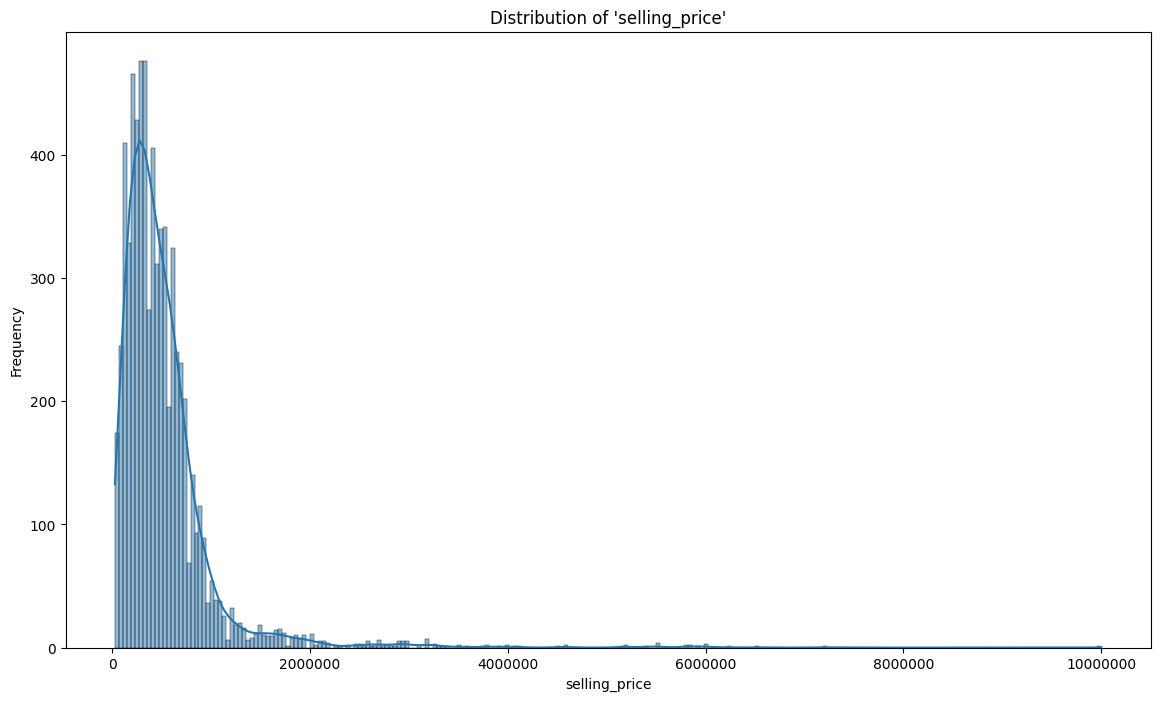

In [30]:
import matplotlib.ticker as mticker

# Histogram for selling_price
plt.figure(figsize=(14,8))
ax = sns.histplot(data=df_copy["selling_price"], kde=True)

plt.title("Distribution of 'selling_price'")
plt.xlabel("selling_price")
plt.ylabel("Frequency")

ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='x')

plt.savefig(f'{plots_saving_path}/selling_price_histogram_before_FE.png')
plt.show()
plt.close()


as mentioned in previous statistical analysis, selling price is right skewed which will be addressed in feature engineering

#### Numerical Features

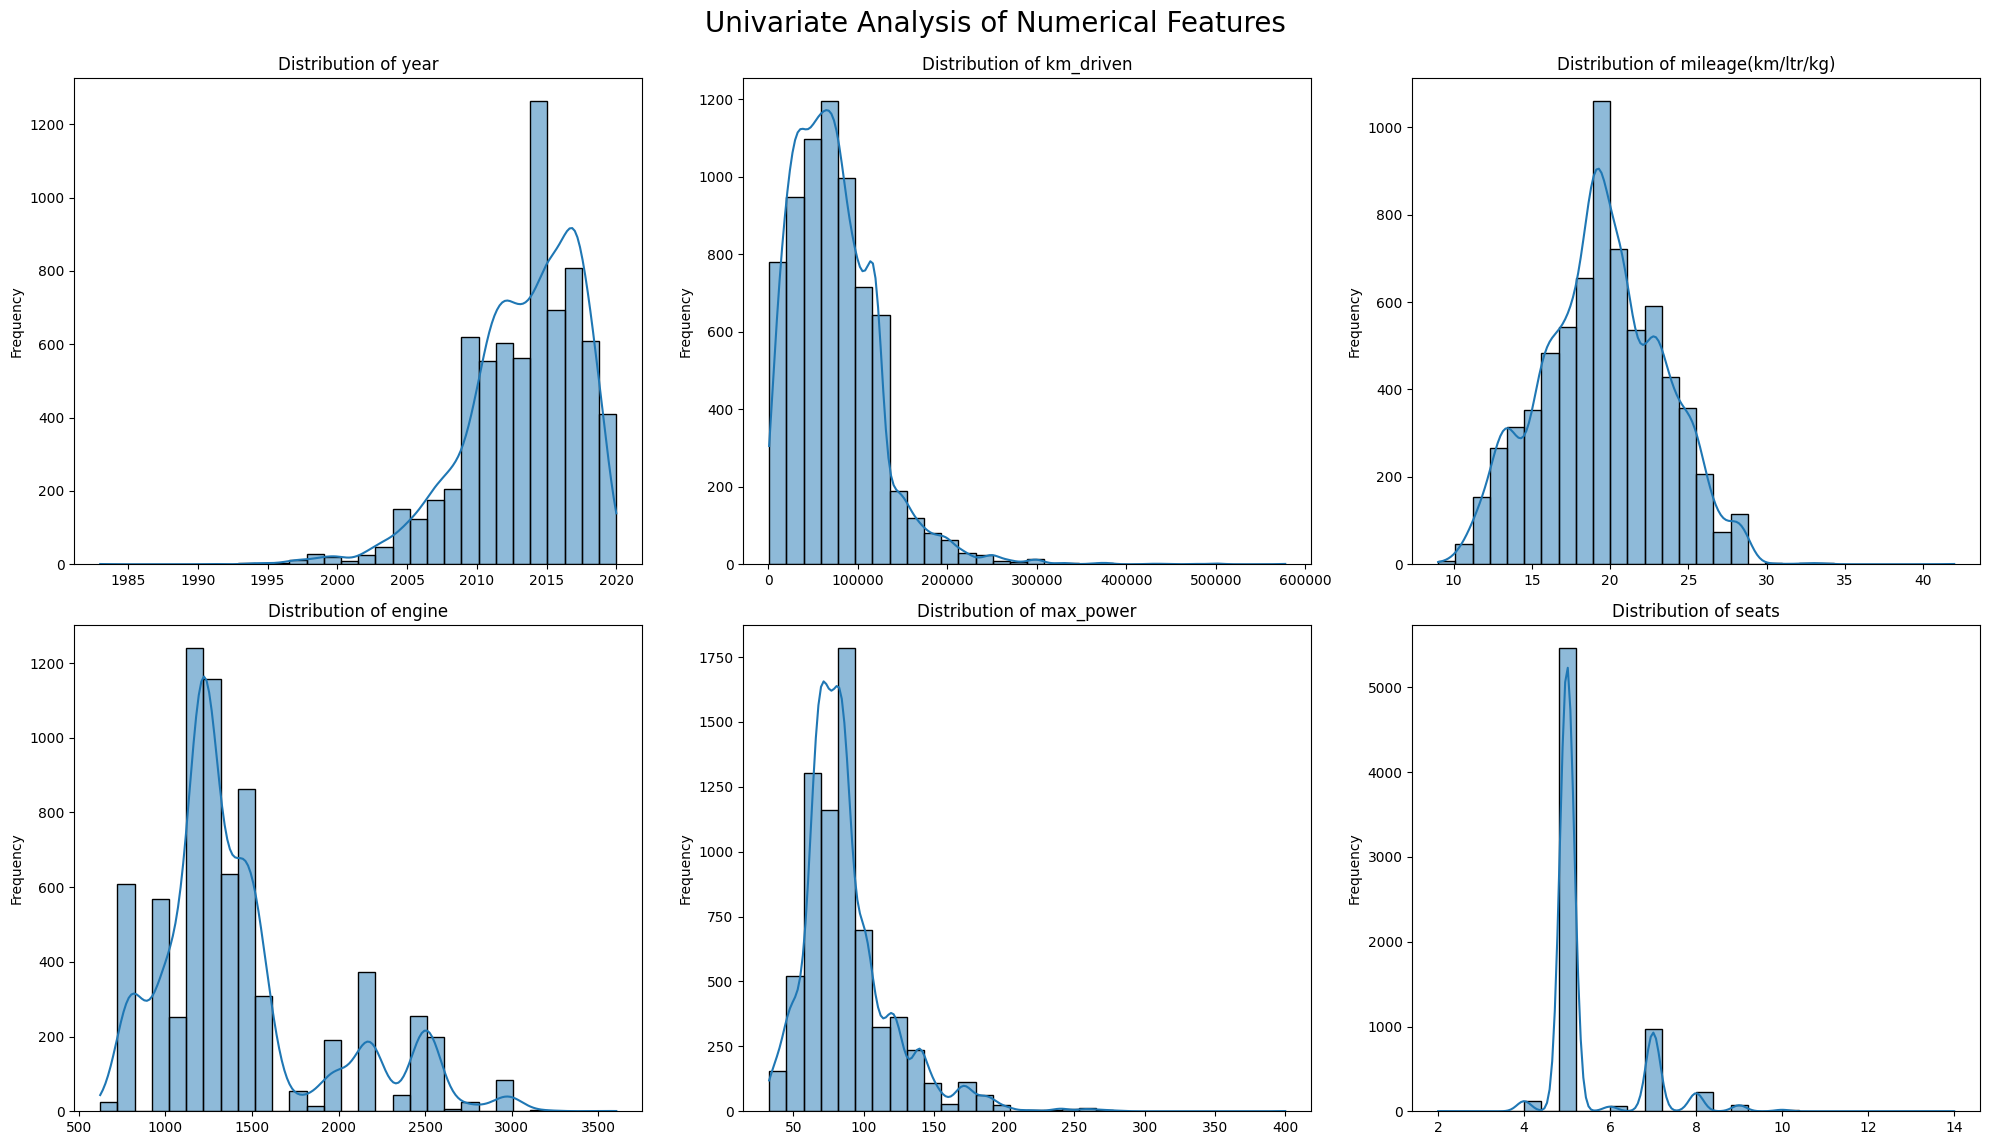

In [31]:
# Subplots for all numerical features
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Univariate Analysis of Numerical Features', fontsize=20)

numerical_cols = ['year', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'max_power', 'seats']

for col, ax in zip(numerical_cols, axes.flatten()):
    sns.histplot(data=df_copy, x=col, kde=True, ax=ax, bins=30)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')


plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()
plt.savefig(f'{plots_saving_path}/numerical_histogram_before_FE.png')
plt.close()

#### LLM comment 
*   **`year`:** The data is heavily **left-skewed**, with most cars manufactured after 2010.
*   **`km_driven` & `max_power`:** Both distributions are **right-skewed**, with most cars having lower mileage and power, but a long tail of high-performance/high-usage vehicles.
*   **`mileage(km/ltr/kg)`:** This is the most **normally distributed (bell-shaped)** feature, centered around 19-20 km/ltr.
*   **`engine`:** The distribution is **bimodal**, with a major peak around 1200cc (compact cars) and a smaller peak around 2200cc (SUVs), indicating distinct vehicle classes in the dataset.
*   **`seats`:** This is a **discrete distribution** dominated by **5-seater** cars, with a smaller, significant group of **7-seater** vehicles.

#### Categorical features
Before doing univariate analysis on categorical features, it is noticeable that the name feature starts with brand name trailed by the model, let's extract brand and model as brand value is crucial for resale prices.

In [32]:
# Extracting brand
df_copy['brand'] = df_copy['name'].apply(lambda x: x.split(' ')[0])

# Extracting model
df_copy['model'] = df_copy['name'].apply(lambda x: ' '.join(x.split(' ')[1:]))

# Droping name
df_copy.drop(columns=['name'], inplace=True)

print(df_copy.head())
print('\n---------------------\n')
print(df_copy["brand"].value_counts())

   year  selling_price  km_driven    fuel seller_type transmission  \
0  2014         450000     145500  Diesel  Individual       Manual   
1  2014         370000     120000  Diesel  Individual       Manual   
2  2006         158000     140000  Petrol  Individual       Manual   
3  2010         225000     127000  Diesel  Individual       Manual   
4  2007         130000     120000  Petrol  Individual       Manual   

          owner  mileage(km/ltr/kg)  engine  max_power  seats    brand  \
0   First Owner               23.40 1248.00      74.00   5.00   Maruti   
1  Second Owner               21.14 1498.00     103.52   5.00    Skoda   
2   Third Owner               17.70 1497.00      78.00   5.00    Honda   
3   First Owner               23.00 1396.00      90.00   5.00  Hyundai   
4   First Owner               16.10 1298.00      88.20   5.00   Maruti   

                    model  
0         Swift Dzire VDI  
1  Rapid 1.5 TDI Ambition  
2      City 2017-2020 EXi  
3       i20 Sportz Die

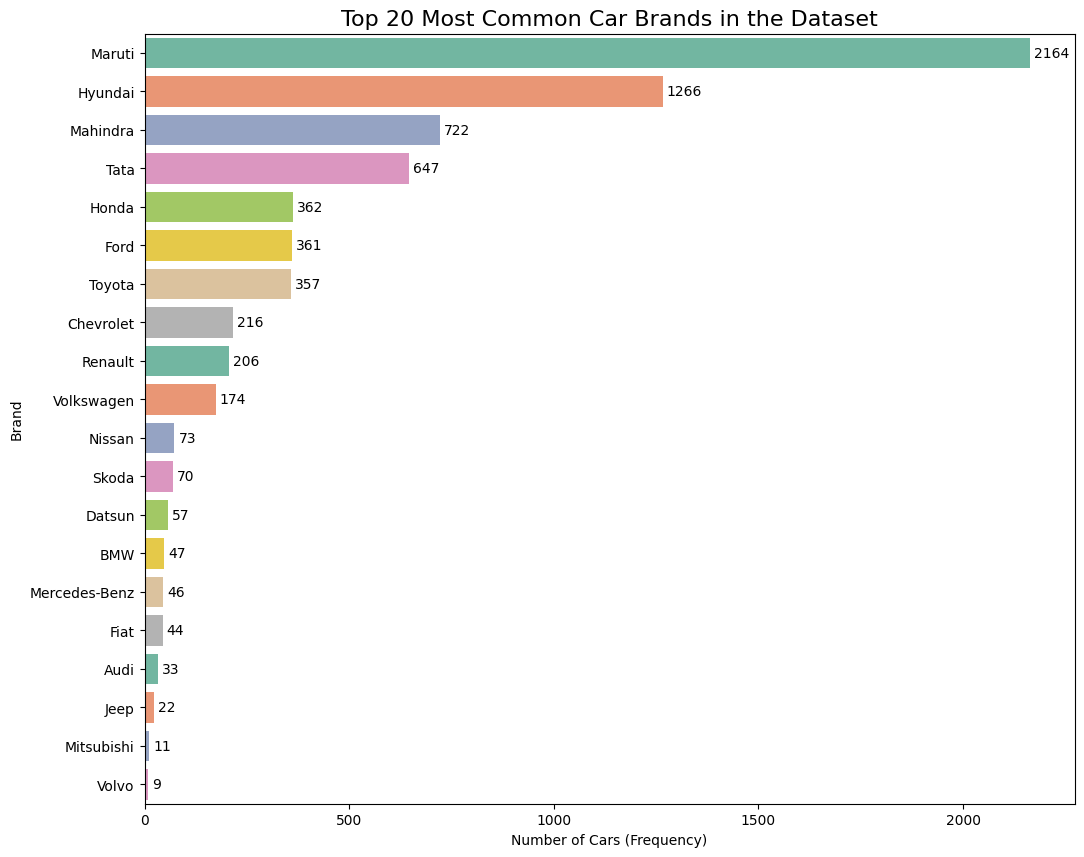

In [33]:
# Brand
plt.figure(figsize=(12, 10))
# Filtering top 20 brands
brand_counts = df_copy['brand'].value_counts().nlargest(20)

ax = sns.barplot(x=brand_counts.values, y=brand_counts.index, palette='Set2')

ax.set_title('Top 20 Most Common Car Brands in the Dataset', fontsize=16)
ax.set_xlabel('Number of Cars (Frequency)')
ax.set_ylabel('Brand')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 10, p.get_y() + p.get_height() / 2, '{:d}'.format(int(width)), ha='left', va='center')

plt.show()
plt.savefig(f'{plots_saving_path}/brands_countplot.png')
plt.close()

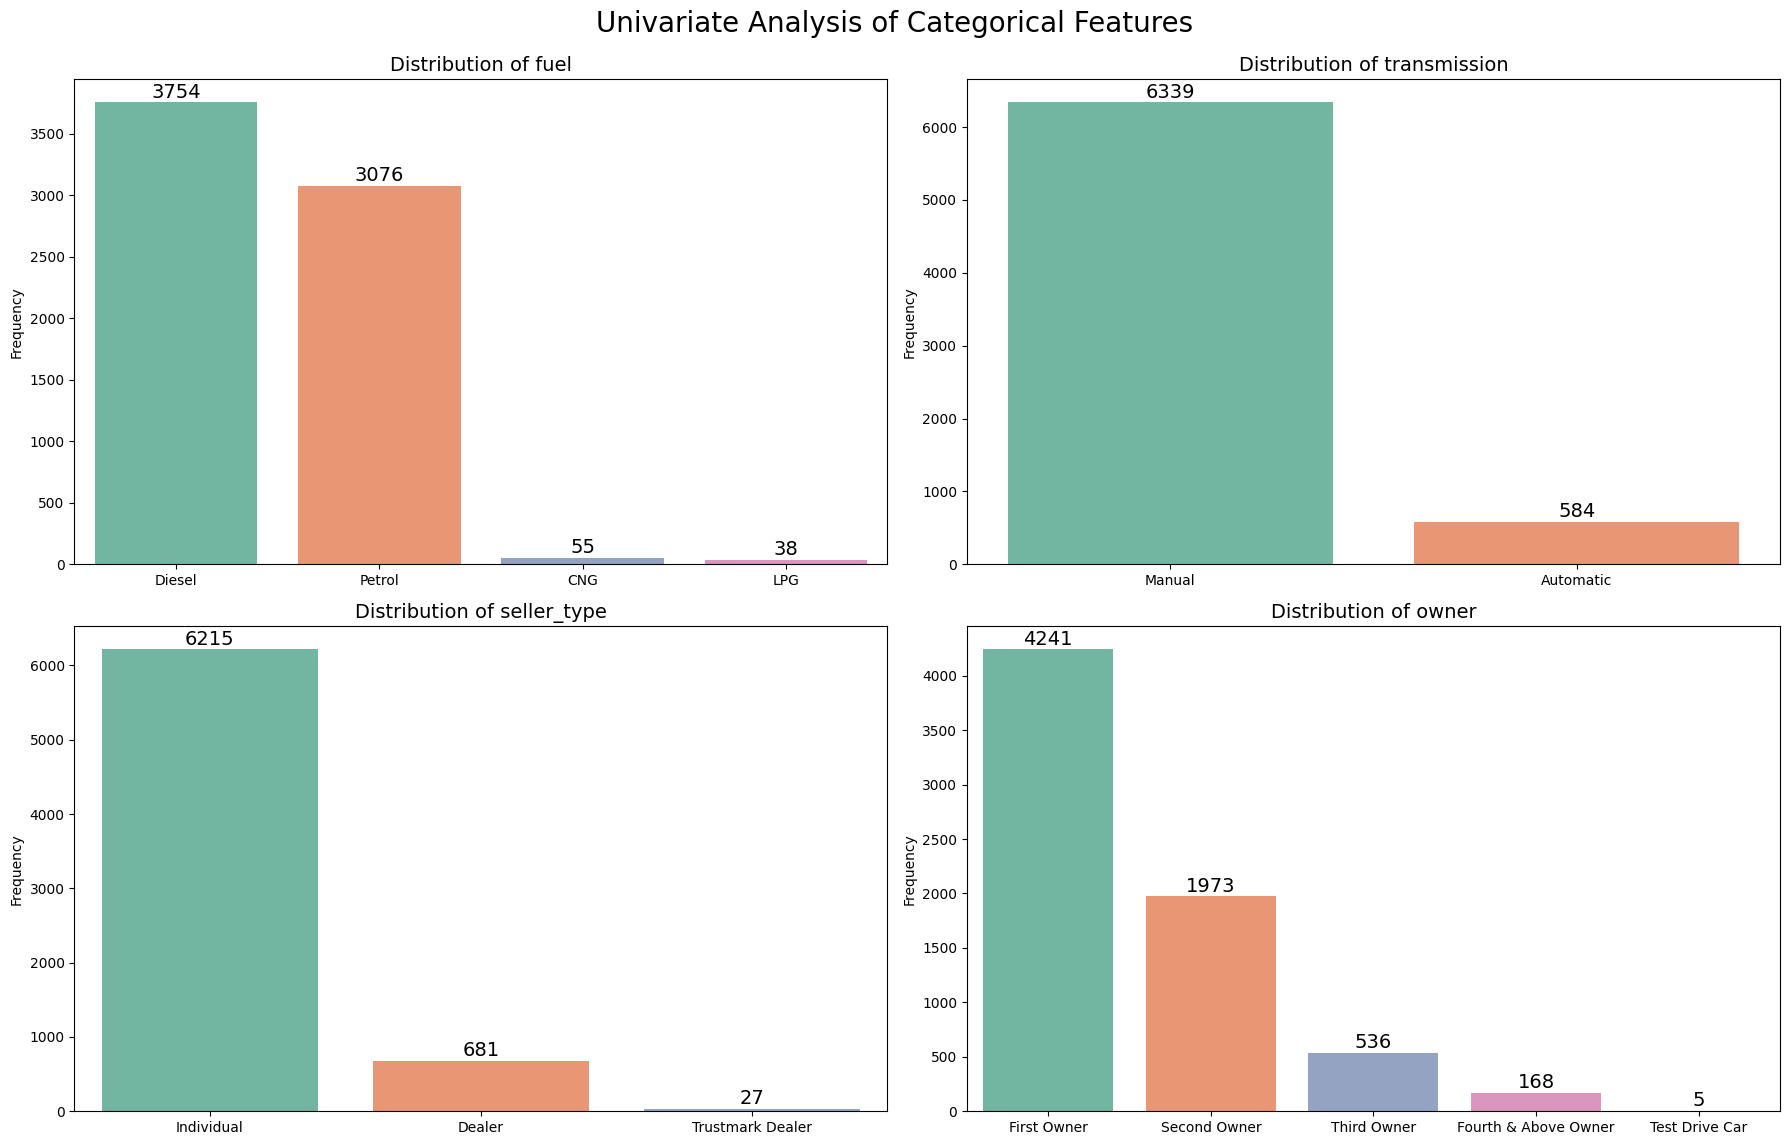

In [34]:
# Countplots for other categorical datas
categorical_cols = ['fuel', 'transmission', 'seller_type', 'owner']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Univariate Analysis of Categorical Features', fontsize=20)

axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    sns.countplot(x=col, data=df_copy, ax=ax, palette='Set2', order=df_copy[col].value_counts().index)
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel('') 
    ax.set_ylabel('Frequency')
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width() / 2, y=height + (ax.get_ylim()[1] * 0.01), s=f'{int(height)}', ha='center', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()
plt.savefig(f'{plots_saving_path}/categories_countplot.png')
plt.close()

#### LLM Comment
*   **`brand`**: Brands like **Maruti**, **Hyundai**, **Mahindra** and **Tata** dominate the dataset, which is representative of the Indian car market.
*   **`fuel`**: The dataset is fairly balanced between **Diesel (3754)** and **Petrol (3076)** cars, which are the dominant fuel types. CNG and LPG cars are very rare in comparison, which might make it hard for a model to learn their specific price patterns.

*   **`transmission`**: There is a significant class imbalance. **Manual** transmission cars **(6339)** vastly outnumber **Automatic** cars **(584)**. This is typical for the market but means the model will have much more data to learn from for manual cars.

*   **`seller_type`**: The dataset is overwhelmingly composed of cars sold by an **Individual (6215)**. Cars sold by **Dealers (681)** are much less common. This feature will likely be a strong indicator of price.

*   **`owner`**: Most cars are **First Owner (4241)**, followed by **Second Owner (1973)**. The number drops off sharply for third, fourth, and test drive cars. This confirms the expected trend that newer/less-used cars are more common on the market.

### Bivariate Analysis
#### Numerical Features

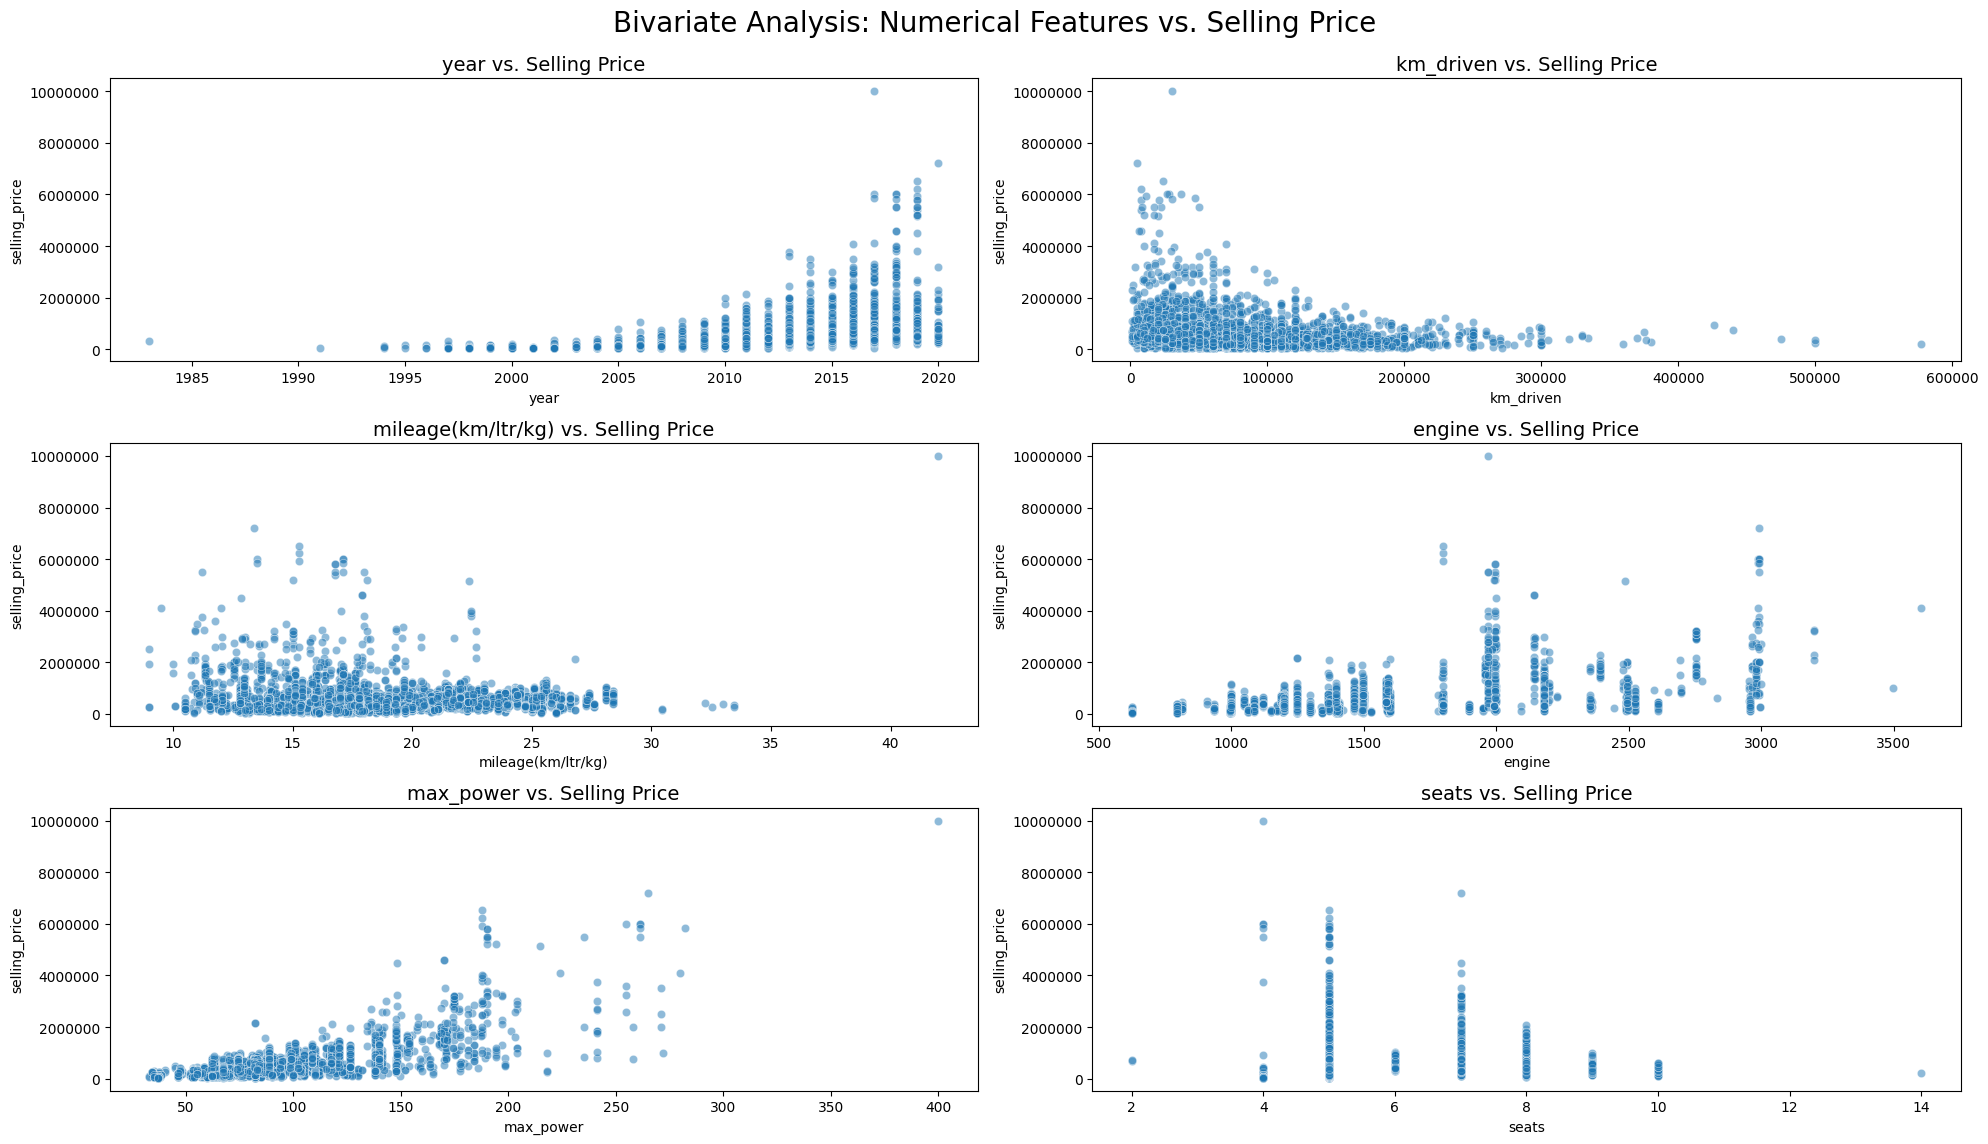

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12))
fig.suptitle('Bivariate Analysis: Numerical Features vs. Selling Price', fontsize=20)

axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    sns.scatterplot(data=df_copy, x=col, y='selling_price', ax=ax, alpha=0.5)
    ax.set_title(f'{col} vs. Selling Price', fontsize=14)
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y')
    ax.ticklabel_format(style='plain', axis='x')

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()
plt.savefig(f'{plots_saving_path}/numerical_scatterplot.png')
plt.close()

#### LLM comment

*   **`year` vs. Price:** Strong positive correlation. Newer cars are more expensive.
*   **`km_driven` vs. Price:** Clear negative correlation. Higher mileage leads to lower prices.
*   **`max_power` & `engine` vs. Price:** Strong positive correlation. More powerful cars with larger engines are consistently more expensive. `max_power` shows a particularly strong linear trend.
*   **`mileage` vs. Price:** No strong or clear trend. The relationship is weak and scattered.
*   **`seats` vs. Price:** Acts like a categorical feature. While most cars are 5-seaters, cars with 7 or 8 seats can command higher prices.

#### Categorical Features


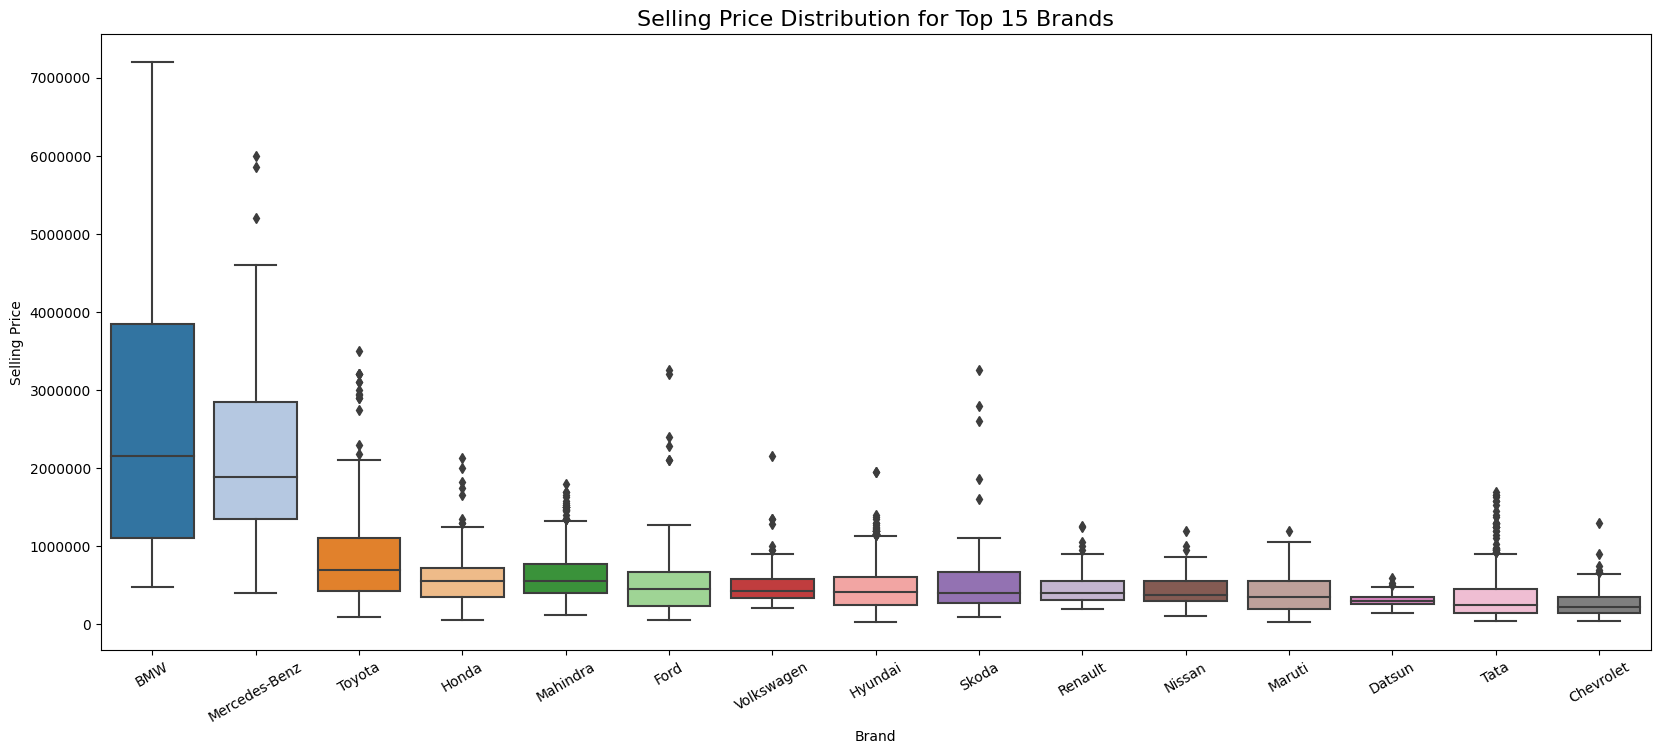

In [36]:
# Identify the top 15 most frequent brands
top_15_brands = df_copy['brand'].value_counts().nlargest(15).index

# Filter the DataFrame to only include these top brands
df_top_brands = df_copy[df_copy['brand'].isin(top_15_brands)]

# To make the plot more insightful, ordering the brands by their median selling price
brand_order = df_top_brands.groupby('brand')['selling_price'].median().sort_values(ascending=False).index

plt.figure(figsize=(20, 8))
ax_brand = sns.boxplot(x='brand', y='selling_price', data=df_top_brands, order=brand_order, palette='tab20')

ax_brand.set_title('Selling Price Distribution for Top 15 Brands', fontsize=16)
ax_brand.set_xlabel('Brand')
ax_brand.set_ylabel('Selling Price')
ax_brand.tick_params(axis='x', rotation=30)

# Use a non-scientific format for the y-axis
ax_brand.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax_brand.ticklabel_format(style='plain', axis='y')

plt.show()
plt.savefig(f'{plots_saving_path}/brands_boxplot.png')
plt.close()

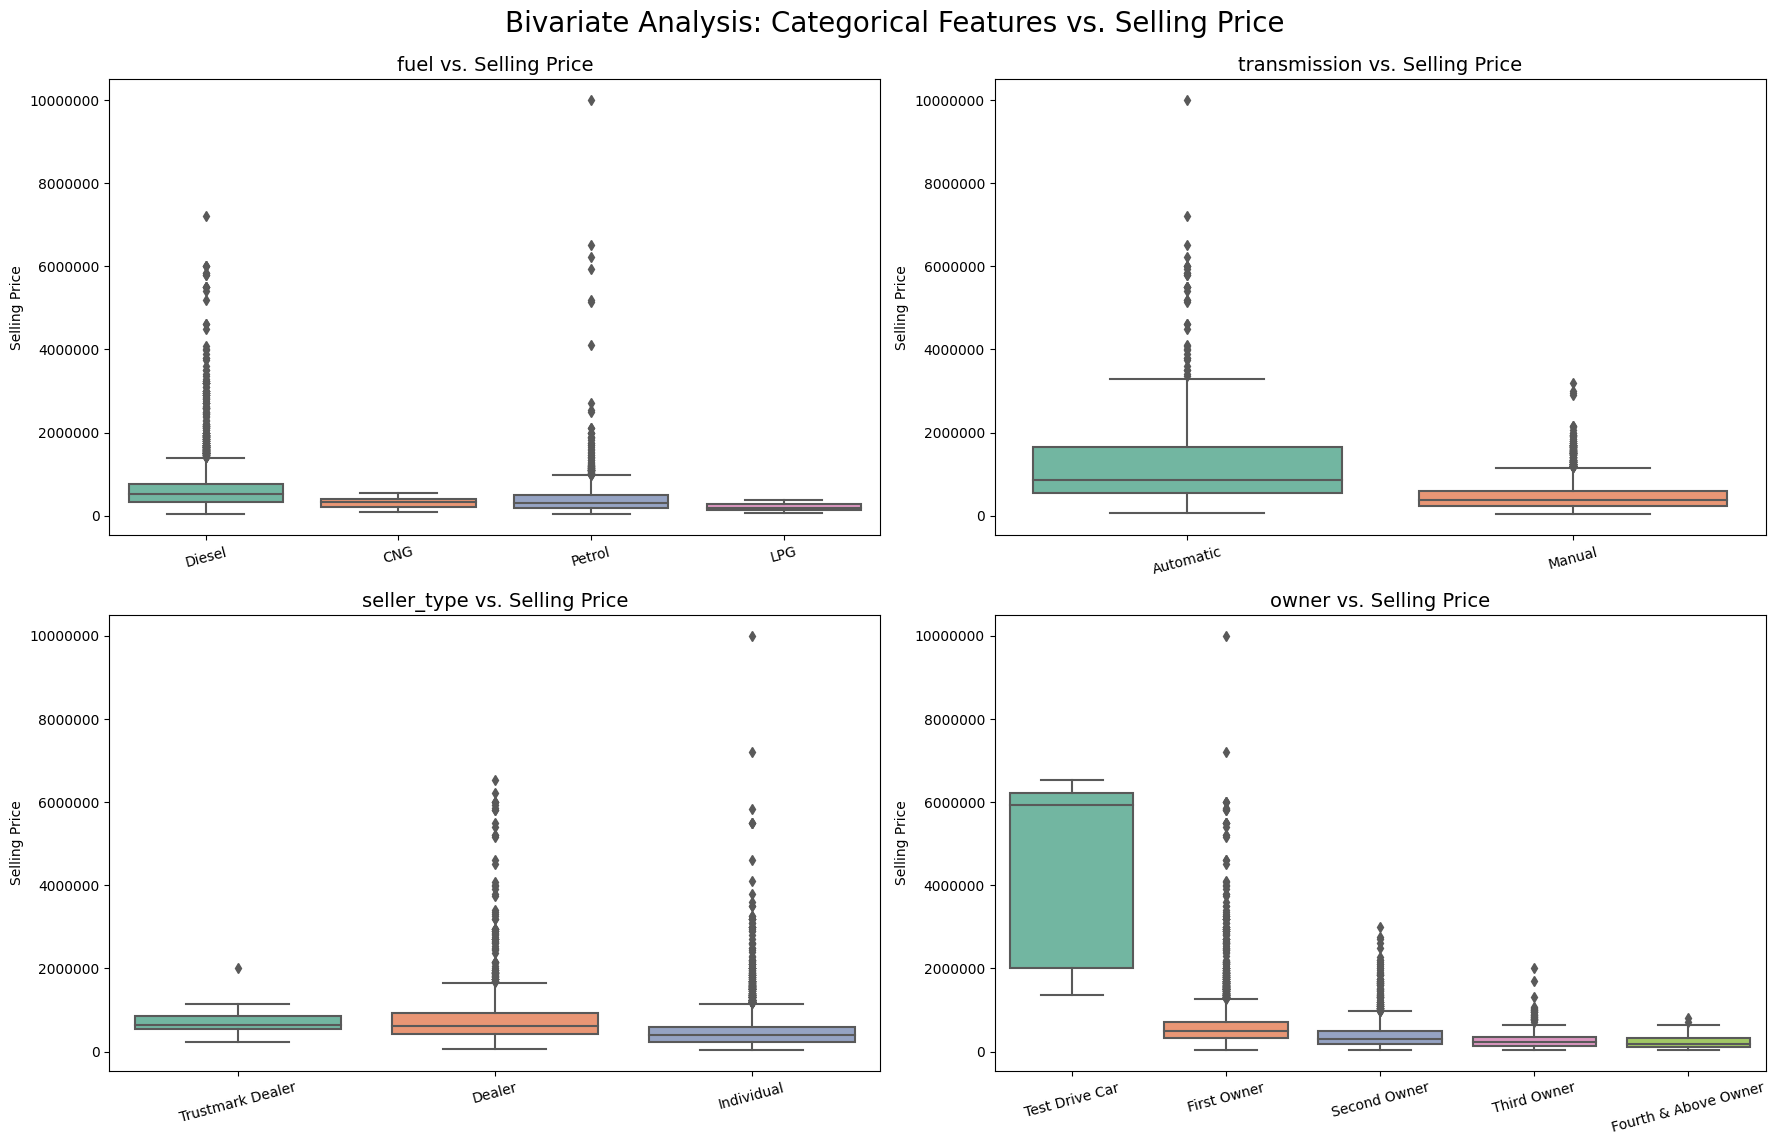

In [37]:
# Other categories
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Bivariate Analysis: Categorical Features vs. Selling Price', fontsize=20)

axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    
    order = df_copy.groupby(col)['selling_price'].median().sort_values(ascending=False).index
    
    # Create the box plot
    sns.boxplot(x=col, y='selling_price', data=df_copy, ax=ax, palette='Set2', order=order)
    
    ax.set_title(f'{col} vs. Selling Price', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Selling Price')
    
    # Format the y-axis to be readable (no scientific notation)
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y')
    
    # Rotate labels if needed
    ax.tick_params(axis='x', rotation=15)

# Adjust the layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()
plt.savefig(f'{plots_saving_path}/categories_boxplot.png')
plt.close()

#### LLM comment
##### **Brand**
*   **Clear Price Hierarchy:** There's a distinct tier system. Luxury brands like `BMW` and `Mercedes-Benz` command the highest median prices. They are followed by a premium/SUV tier including `Toyota` and `Mahindra`. The majority of brands like `Honda`, `Hyundai`, and `Maruti` occupy a competitive mid-to-budget range.
*   **Outliers:** The dots (outliers) represent the most expensive models within a brand. For instance, the outliers for `Toyota` are likely the high-end `Fortuner` or `Innova Crysta` models, while the main box represents more common models like the `Etios`. These are valid data points and crucial for the model to understand the full price range of a brand.

##### **Other Categorical Features**

*   **`fuel`:** **Diesel** cars show a significantly higher median price and wider price distribution than Petrol cars. CNG and LPG cars are clustered at the low end, indicating they are primarily budget-friendly options.

*   **`transmission`:** **Automatic** cars are substantially more expensive than **Manual** cars. The difference in median price is very large, making this a powerful predictive feature.

*   **`seller_type`:** Cars sold by **Dealers** have a higher median price than those sold by **Individuals**. This is logical, as dealers often sell certified or newer vehicles. The "Test Drive Car" category in the `owner` plot shows a similar high-value trend.

*   **`owner`:** There is a clear, predictable **inverse relationship** between the number of previous owners and the selling price. **First Owner** cars are the most expensive, and the price drops consistently for Second, Third, and subsequent owners.

**Overall Conclusion:**
All these categorical features show strong, logical relationships with the selling price. `brand`, `transmission`, and `owner` appear to be particularly strong predictors. The outliers are not errors but represent real, high-end models within each category, providing valuable information for the model.

#### Correlation matrix

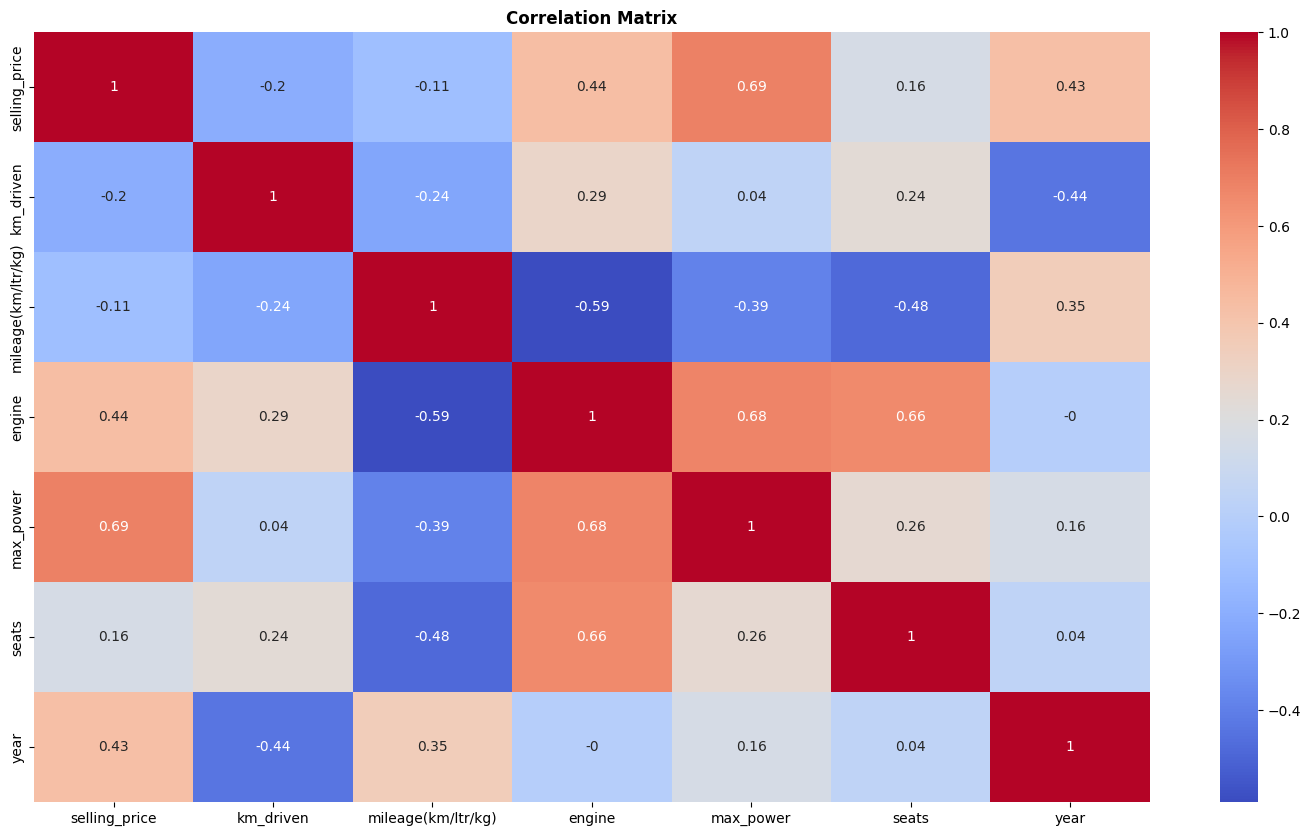

In [38]:
# Correlation matrix
numerical_cols_for_corr = ['selling_price', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'max_power', 'seats', 'year']
corr_matrix = df_copy[numerical_cols_for_corr].corr().round(2)

plt.figure(figsize = (18,10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix', fontweight='bold')
plt.show()
plt.savefig(f'{plots_saving_path}/corr_matrix.png')
plt.close()

#### LLM comment

#### **Relationships with `selling_price` (The First Row/Column):**

*   **`max_power` (Correlation: 0.69):** This is the **strongest positive correlation**. As max power increases, the selling price tends to increase significantly. This confirms what we saw in the scatter plot.
*   **`year` (Correlation: 0.43):** A solid **positive correlation**. As the year increases (car gets newer), the price increases. This justifies our plan to create a `car_age` feature, which will have a strong negative correlation.
*   **`engine` (Correlation: 0.44):** A good **positive correlation**. Larger engines are associated with higher prices.
*   **`km_driven` (Correlation: -0.20):** A **weak-to-moderate negative correlation**. As kilometers increase, the price tends to decrease. The correlation isn't stronger because the relationship is likely not perfectly linear.
*   **`mileage` (Correlation: -0.11):** A very **weak negative correlation**. This suggests that fuel efficiency, by itself, is not a strong linear predictor of price.

#### **Relationships Between Other Features (Multicollinearity):**

*   **`engine` and `max_power` (Correlation: 0.68):** There is a **strong positive correlation** between engine size and max power. This is completely logical—bigger engines are generally more powerful. This is a classic case of multicollinearity.
*   **`engine` and `mileage` (Correlation: -0.59):** A **strong negative correlation**. Bigger engines tend to have lower fuel efficiency (mileage). This also makes perfect sense.
*   **`year` and `km_driven` (Correlation: -0.44):** A moderate **negative correlation**. Older cars (lower year) tend to have been driven more kilometers.


## Feature Engineering
### New Features
- **`brand`** and **`model`** features are already extracted from **`name`**
- Other features recommended by LLM are:
    - **`car_age`**: While `year` is a good predictor, `car_age` (`current_year - year`) provides a more direct and intuitive measure of depreciation. A model can more easily learn a simple negative relationship ("older cars are cheaper") than a positive one tied to a specific year. This feature is also more robust over time.
    - **`km_per_year` (from `km_driven` and `car_age`)**: This feature captures the **intensity of usage**, which is more telling than total mileage alone. A 2-year-old car with 50,000 km has been used much more heavily than a 10-year-old car with the same mileage. This provides a richer signal about the car's condition and potential wear.
---
#### **Potential Future Features**

For this project, we are focusing on the most impactful and standard features first. The following are excellent ideas for future improvements but would add complexity that isn't necessary for building a strong initial model.

*   **`is_luxury` (Binary Flag):**
    *   **What:** A `1` if the brand is a known luxury brand (BMW, Audi, etc.), otherwise `0`.
    *   **Why not now?** Powerful tree-based models like XGBoost can learn this distinction implicitly from the one-hot encoded `brand` feature. While a good idea, it's not essential for the first version.

*   **`power_to_engine_ratio`:**
    *   **What:** `max_power / engine`.
    *   **Why not now?** This captures engine efficiency, but the individual `max_power` and `engine` features are already very strong predictors. This new feature might add only marginal value while making the model slightly more complex.

Sticking to `car_age` and `km_per_year` is a robust and efficient strategy to get a high-performing baseline model.

In [39]:
# The final cleaned and feature added dataset 
df_final = df_copy.copy()

# Extracting 'car_age' feature
# Setting the current_year relative to the data's latest entry rather than the current year
current_year = df_final['year'].max() + 1
df_final['car_age'] = current_year - df_final['year']

# Creating 'km_per_year'
df_final['km_per_year'] = df_final['km_driven'] / df_final['car_age']

df_final.drop(columns=['year'], inplace=True)
df_final.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,brand,model,car_age,km_per_year
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.00,74.00,5.00,Maruti,Swift Dzire VDI,7,20785.71
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.00,103.52,5.00,Skoda,Rapid 1.5 TDI Ambition,7,17142.86
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.00,78.00,5.00,Honda,City 2017-2020 EXi,15,9333.33
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.00,90.00,5.00,Hyundai,i20 Sportz Diesel,11,11545.45
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.00,88.20,5.00,Maruti,Swift VXI BSIII,14,8571.43


In [40]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6923 entries, 0 to 8125
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   selling_price       6923 non-null   int64  
 1   km_driven           6923 non-null   int64  
 2   fuel                6923 non-null   object 
 3   seller_type         6923 non-null   object 
 4   transmission        6923 non-null   object 
 5   owner               6923 non-null   object 
 6   mileage(km/ltr/kg)  6923 non-null   float64
 7   engine              6923 non-null   float64
 8   max_power           6923 non-null   float64
 9   seats               6923 non-null   float64
 10  brand               6923 non-null   object 
 11  model               6923 non-null   object 
 12  car_age             6923 non-null   int64  
 13  km_per_year         6923 non-null   float64
dtypes: float64(5), int64(3), object(6)
memory usage: 811.3+ KB


In [41]:
df_final.describe()

,selling_price,km_driven,mileage(km/ltr/kg),engine,max_power,seats,car_age,km_per_year
count,6923.00,6923.00,6923.00,6923.00,6923.00,6923.00,6923.00,6923.00
mean,517312.97,73470.11,19.50,1425.36,87.59,5.42,7.58,10603.61
std,519866.21,48549.41,3.88,487.03,31.26,0.97,4.08,6964.73
min,29999.00,1000.00,9.00,624.00,32.80,2.00,1.00,200.00
25%,250000.00,40000.00,17.00,1197.00,68.00,5.00,4.00,6153.85
50%,400000.00,70000.00,19.33,1248.00,81.86,5.00,7.00,9166.67
75%,634500.00,100000.00,22.32,1498.00,99.00,5.00,10.00,13333.33
max,10000000.00,577414.00,42.00,3604.00,400.00,14.00,38.00,120000.00


In [42]:
# Saving this final cleaned dataset with new features before feature scaling
df_final.to_csv("./car_processed.csv", index=False)

### Feature Scaling
While Feature scaling is not necessary to our tree based model considerations, to give linear models like ridge regression, KNN and SVM their best shot, we will log transform right skewed target and features with standard scaling. 

### Train-test Split
The dataset will be split in 80:20 train and test split. While a val split could be made, I am going to use RandomSearchCV with 5 fold cross validation to validate model's best parameters. 

In [43]:
# Separating features and target
X = df_final.drop('selling_price', axis=1)
y = df_final['selling_price']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Instances in train: {len(y_train)}')
print(f'Instance in test: {len(y_test)}')

Instances in train: 5538
Instance in test: 1385


In [44]:
# From our EDA, we know these are skewed
skewed_features = ['km_driven', 'max_power', 'engine', 'km_per_year']

# All other numerical features
non_skewed_numerical_features = ['seats', 'car_age'] # 'car_age' is less skewed

categorical_features = X.select_dtypes(include='object').columns.tolist()

#### Log Transformation

In [45]:
X_train_scaled = X_train.copy()
y_train_scaled = y_train.copy()

for col in skewed_features:
    X_train_scaled[col] = np.log1p(X_train_scaled[col])

y_train_scaled = np.log1p(y_train_scaled)

##### Selling price histogram

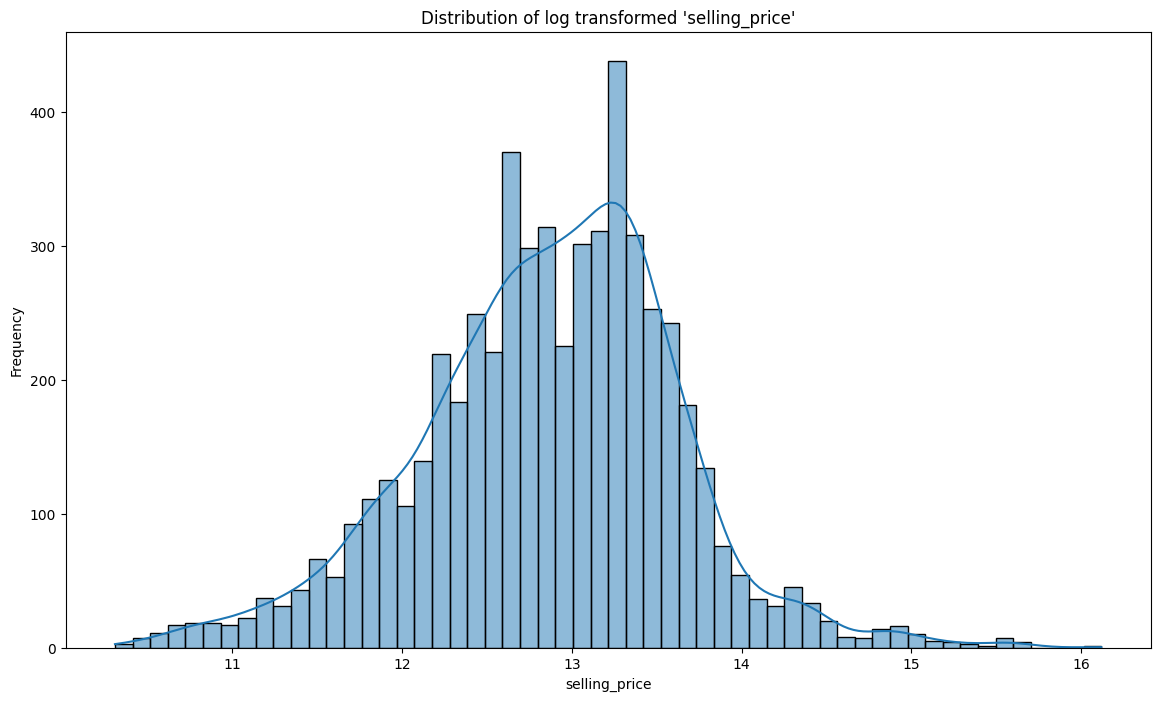

In [46]:
# Histogram for selling_price
plt.figure(figsize=(14,8))
ax = sns.histplot(data=y_train_scaled, kde=True)

plt.title("Distribution of log transformed 'selling_price'")
plt.xlabel("selling_price")
plt.ylabel("Frequency")

ax.ticklabel_format(style='plain', axis='x')

plt.show()
plt.close()


##### Log-transforming other skewed features

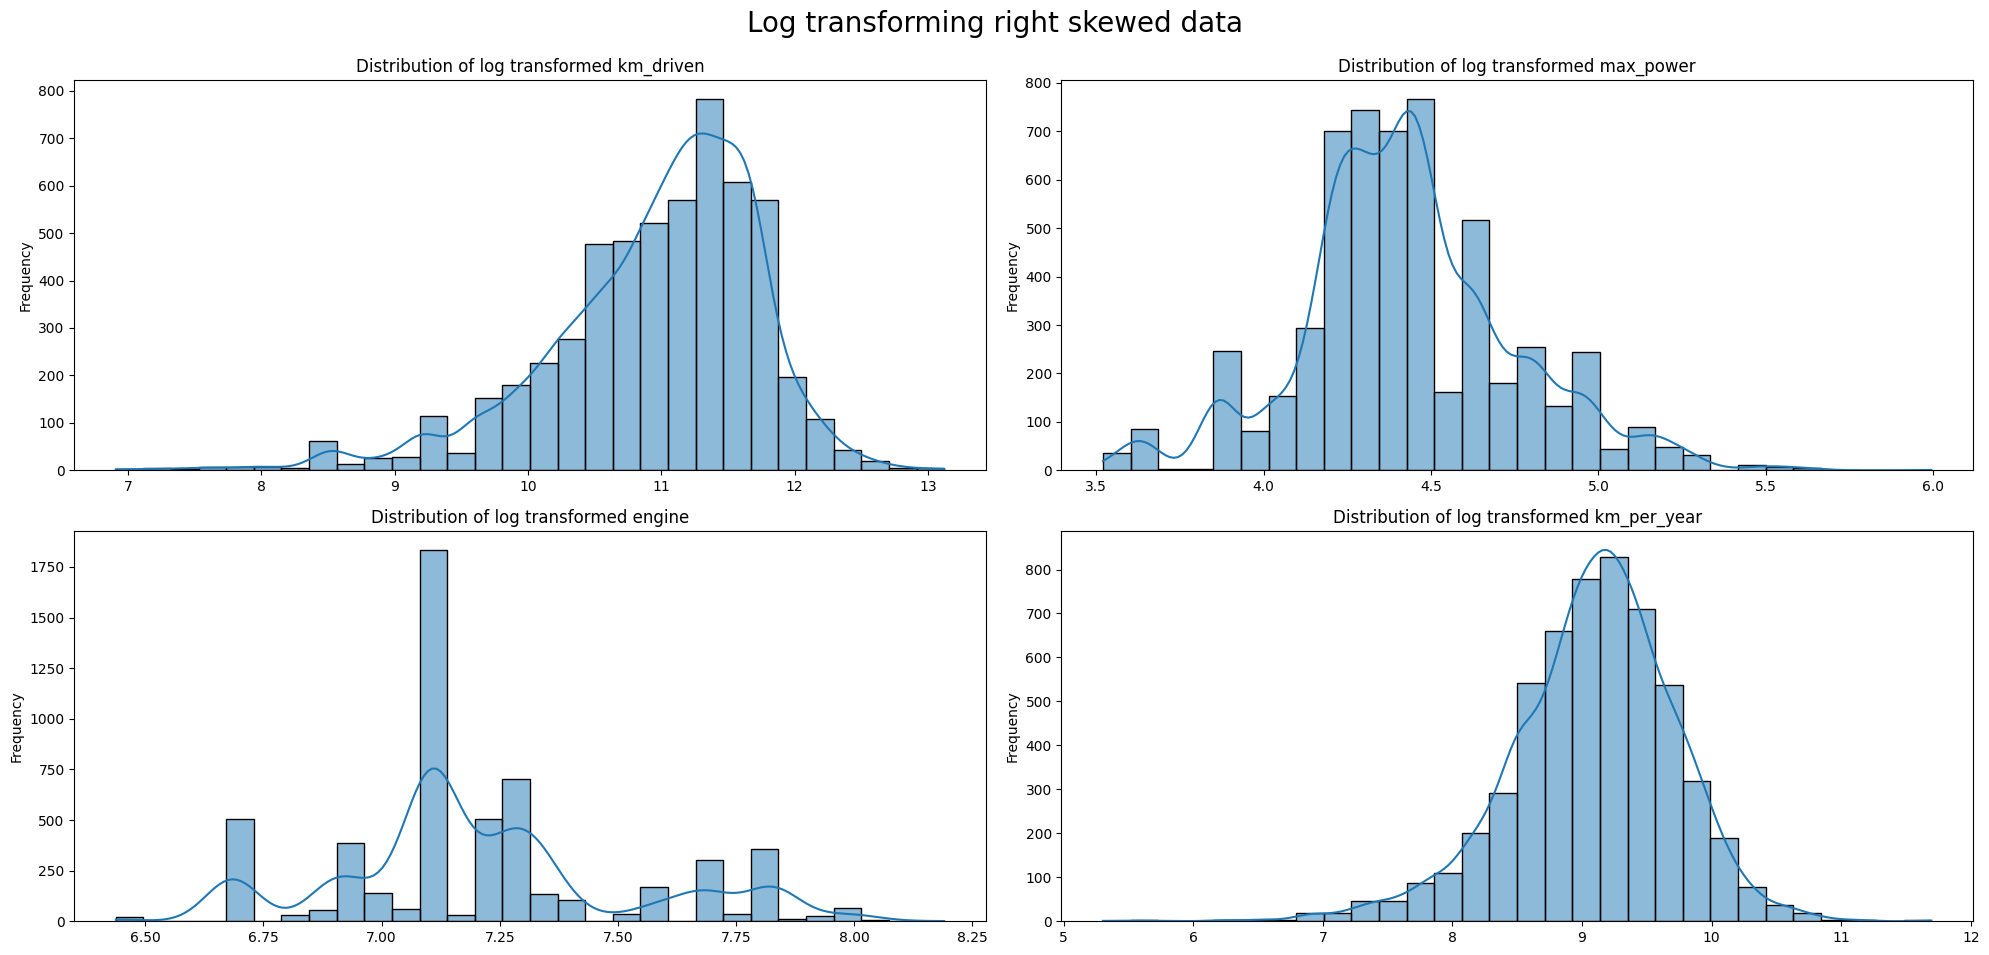

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Log transforming right skewed data', fontsize=20)

for col, ax in zip(skewed_features, axes.flatten()):
    sns.histplot(data=X_train_scaled, x=col, kde=True, ax=ax, bins=30)
    ax.set_title(f'Distribution of log transformed {col}')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')


plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()
plt.close()

#### LLM comment
The log transformation successfully symmetrizes most features. Interestingly, `km_driven` becomes left-skewed after the transformation, which reflects the high concentration of relatively low-mileage cars in the original dataset. Nevertheless, this transformed feature is still more suitable for linear models than the original version due to the reduced influence of extreme high-mileage outliers

#### StandardScaler

In [48]:
numerical_features = X_train.select_dtypes(include=np.number).columns

# Initialize the scaler
scaler = StandardScaler()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train_scaled[numerical_features])

y_train_scaled = scaler.fit_transform(y_train_scaled.values.reshape(-1,1))

In [49]:
print(numerical_features)

Index(['km_driven', 'mileage(km/ltr/kg)', 'engine', 'max_power', 'seats',
       'car_age', 'km_per_year'],
      dtype='object')


##### Selling price histogram after scaling

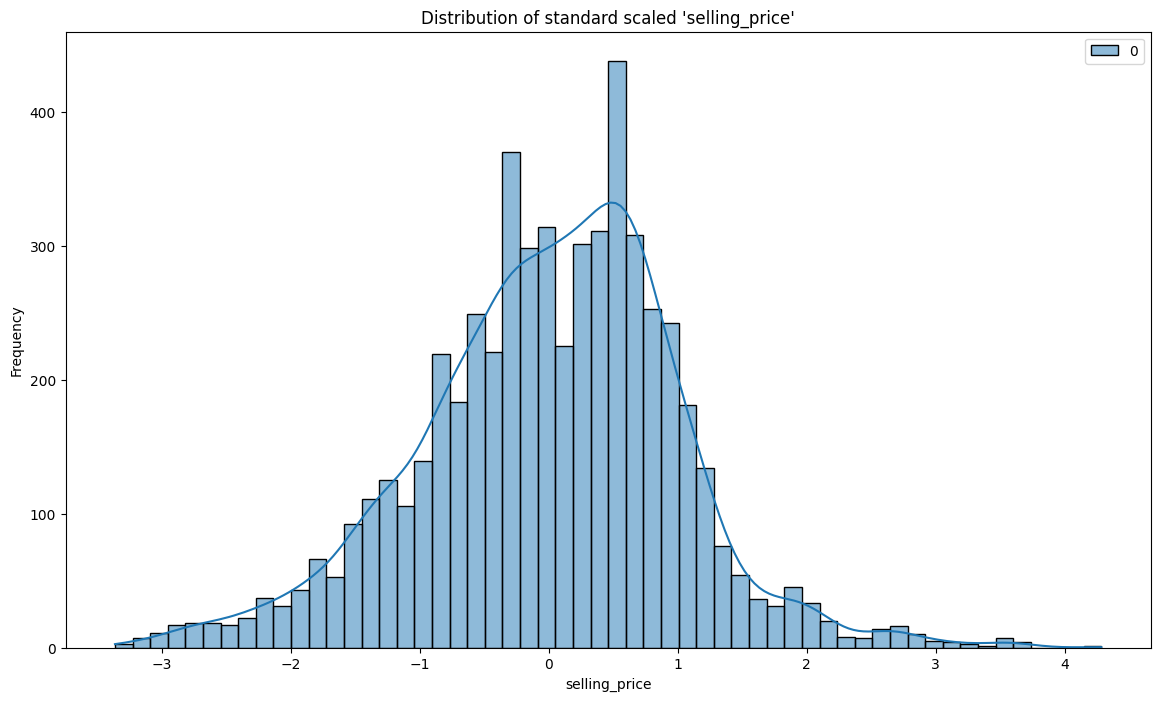

In [50]:
# Histogram for selling_price
plt.figure(figsize=(14,8))
ax = sns.histplot(data=y_train_scaled, kde=True)

plt.title("Distribution of standard scaled 'selling_price'")
plt.xlabel("selling_price")
plt.ylabel("Frequency")

ax.ticklabel_format(style='plain', axis='x')

plt.show()
plt.savefig(f'{plots_saving_path}/selling_price_histogram_after_FE.png')
plt.close()


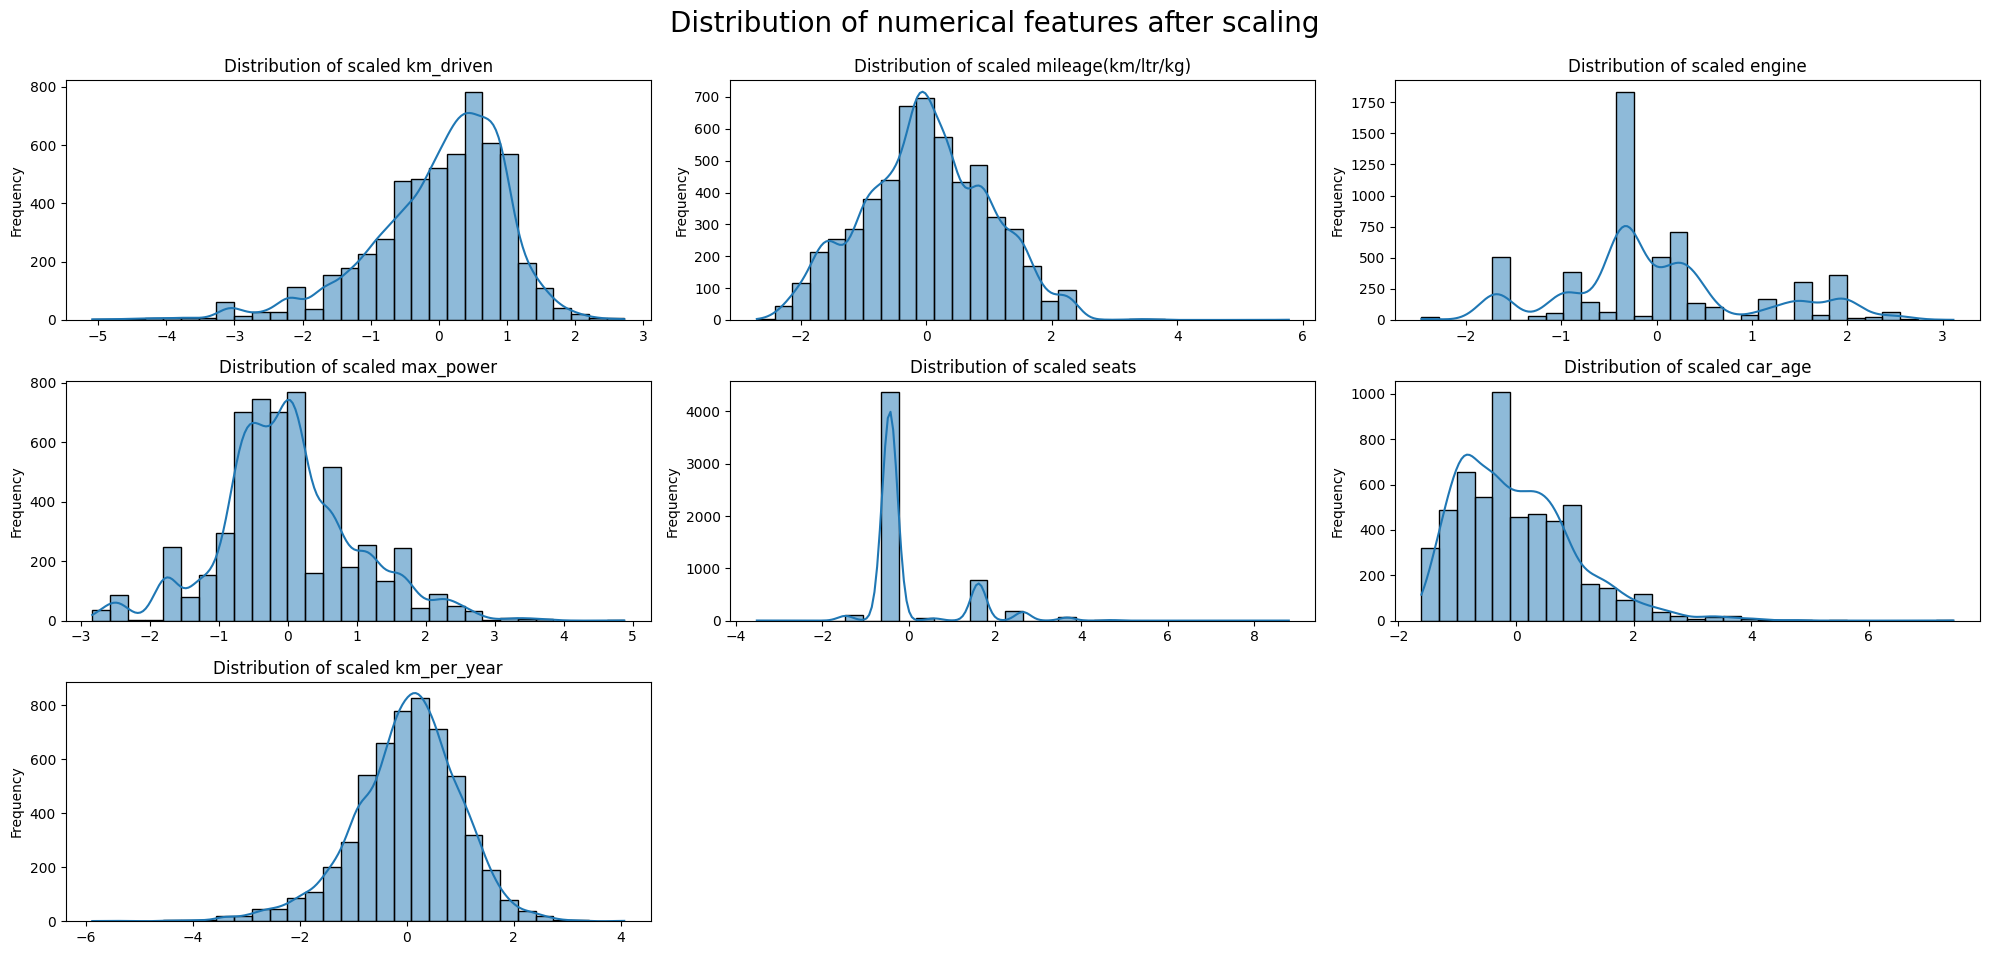

In [51]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
fig.suptitle('Distribution of numerical features after scaling', fontsize=20)

for i, (col, ax) in enumerate(zip(numerical_features, axes.flatten())):
    sns.histplot(data=X_train_scaled, x=col, kde=True, ax=ax, bins=30)
    ax.set_title(f'Distribution of scaled {col}')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

# Hide the last 2 unused subplots
for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()
plt.savefig(f'{plots_saving_path}/numerical_histogram_after_FE.png')
plt.close()

#### LLM comment
*   **Log-Transformed `selling_price`:** The transformation successfully created a symmetric, normal-like distribution centered at 0, which is ideal for regression models.

*   **Standard-Scaled Features:** All numerical features are now on a common scale (mean=0, std=1), which prevents features with large original values from dominating the model. The underlying shapes of their original distributions have been correctly preserved.

### Feature Importance
For feature selection we fit our data to ExtraTreesRegressor ,which is often superior to simpler statistical methods because it can capture non-linear relationships and feature interactions. But, why ExtraTreesRegressor rather than other models that too provide feature ranking? <br/> ExtraTreesRegressor is popular for feature selection because its extreme randomness robustly identifies important features while aggressively suppressing noise, making it faster and more reliable than many alternatives. <br/> ExtraTreesRegressor is a tree model, thus there's no point in fitting scaled data. So the model will be fit with clean unscaled data.

Finding important features...


<Figure size 1200x800 with 0 Axes>

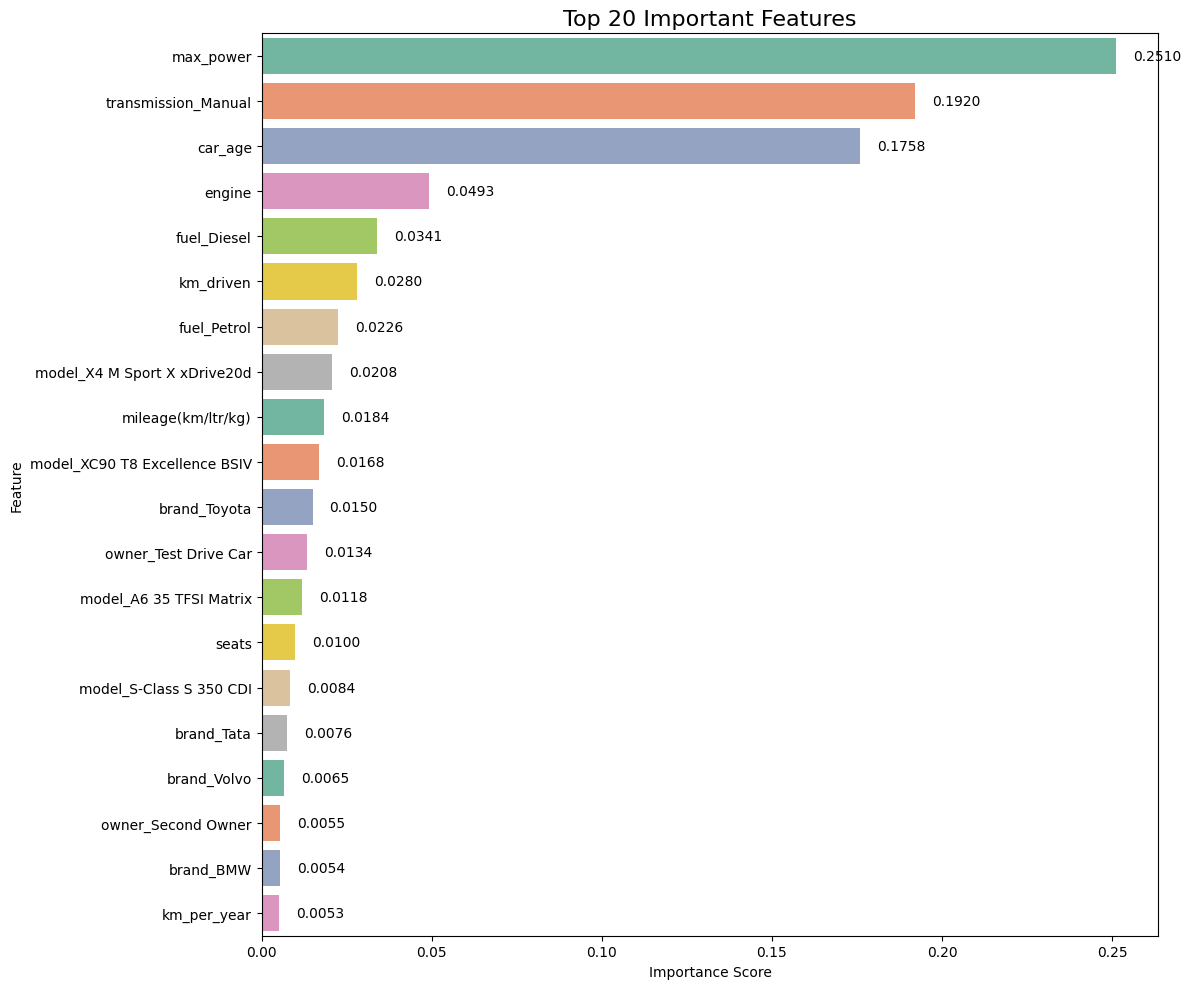

In [55]:
# One Hot encoding categorical datas
X_train_encoded = pd.get_dummies(X_train, drop_first=True)

# Fit clean dataset to ExtraTreesRegressor
selector_model = ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Finding important features...")
selector_model.fit(X_train_encoded, y_train)

# Extracting the feature importances
importances = selector_model.feature_importances_
feature_names = X_train_encoded.columns 
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plotting the top N most important features
plt.figure(figsize=(12, 8))

top_n = 20  # Adjust as needed
top_features = feature_importance_df.head(top_n)

ax = sns.barplot(
    x='importance',
    y='feature',
    data=top_features,
    palette='Set2' 
)

ax.set_title(f'Top 20 Important Features', fontsize=16)
ax.set_xlabel('Importance Score')
ax.set_ylabel('Feature')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.005, p.get_y() + p.get_height() / 2, f'{width:.4f}', ha='left', va='center',fontsize=10)

plt.tight_layout()
plt.savefig(f'{plots_saving_path}/feature_importance.png')  
plt.show()
plt.close()

#### LLM comment
1.  **Dominance of Top Features:** There is a clear hierarchy. The top 3 features—`max_power`, `transmission_Manual`, and `car_age`—are vastly more important than all the others combined. They account for over 60% of the model's predictive power (`0.251 + 0.192 + 0.176 = 0.619`).
2.  **Confirmation of EDA:** The results strongly confirm our findings from the exploratory analysis:
    *   **Power is King:** `max_power` is the single most important feature.
    *   **Age and Transmission are Critical:** `car_age` and whether the car is `transmission_Manual` are the next most important factors. The negative relationship for manual transmission (meaning automatic is more expensive) is a massive price differentiator.
    *   **Physical Attributes Matter:** `engine` size and `km_driven` follow, confirming that core physical stats are key.
    *   **Fuel Type is a Signal:** The `fuel_Diesel` and `fuel_Petrol` flags appear in the top 10, confirming that fuel type is a significant factor.

3.  **Individual Models & Brands as Features:**
    *   It's fascinating to see that specific, high-value `model` flags (like `model_X4 M Sport`, `model_XC90`) and `brand` flags (`brand_Toyota`) appear in the top features. This tells us that beyond general rules, the model also learns that "if the car is *this specific model* or *this specific brand*, it has a unique price."
    *   The `owner_Test Drive Car` feature also has a noticeable impact.
---

However, the features after one hot encoding categorical datas like brand and model will cause feature overcrowding. Thus, SelectFromModel will be trained in the pipeline to learn selection of top 35 features 

## Model Training and Testing